### Dynamic Programming Code for Optimal CP Detection

Implements Levy-Leduc Code to determine optimal number of changepoints across a candidate set 


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def map_intervals(Y,indices):
    """ Maps the indices of the candidate changepoints to the intervals of the data
    """
    partitioned_indices=np.unique(np.concatenate([[0],indices,[len(Y)]]))
    
    intervals={}
    for i in range(len(partitioned_indices)-1):
        intervals[i]=([partitioned_indices[i],partitioned_indices[i+1]])
    return intervals


In [513]:
# TO:DO: Consider constraining continuity of the polynomial instead of mse 

def best_fit_polynomial(Y,intervals,k=1):
    """ Fits a polynomial of order k to the data Y across a given interval
    """
    polynomials=[]
    observed=[]
    for i in range(len(intervals)):
        x=intervals[i]
        
        y=Y[x[0]:x[1]]
        observed.append(y)

        x_range=np.arange(x[0],x[1],1)
        
        poly_coef=np.polyfit(x_range,y,k)
        poly_estimation=poly_coef.dot(np.vstack([x_range**i for i in range(k,-1,-1)]))
        
        polynomials.append(poly_estimation)

    polynomials=np.concatenate(polynomials)
    observed=np.concatenate(observed)

    mse=np.sum((observed-polynomials)**2)
    
    return polynomials,mse

def compute_J(Y,indices,k):
    """ Evaluate cost matrix between each nested pair of changepoints
    """
    cp_mappings=map_intervals(Y,indices)
    mapping_indices=np.arange(len(cp_mappings))
    cost_matrix=np.zeros((len(cp_mappings),len(cp_mappings)))
    
    for i in range(len(mapping_indices)):
        for j in range(i,len(mapping_indices)):
            intervals=[cp_mappings[k] for k in range(i,j+1)]
            cost_matrix[i,j]=best_fit_polynomial(Y,intervals,k=k)[1]

    return cost_matrix

def compute_V(cost_matrix,K_max,indices):
    """ Computes the optimal cost and changepoint locations
    """
   
    k=len(indices)+1
    
    optimal_cost=np.zeros((K_max+1,k))
    optimal_loc=np.zeros((K_max+1,k))
    
    
    # no changepoints; best RSE is the sum of squared errors
    for i in range(k):
        optimal_cost[0,i]=cost_matrix[0,i]

    # iterate solving subproblems from bottom up  
    for k_i in range(1,K_max):
        for j in range(k_i+1,k):
 
            optimal_cost[k_i-1,j-1]=np.min(optimal_cost[k_i-1,k_i-1:j-1]+cost_matrix[k_i:j,j])
            optimal_loc[k_i-1,j-1]=np.argmin(optimal_cost[k_i-1,k_i-1:j-1]+cost_matrix[k_i:j,j])+k_i-1
    
    return optimal_cost,optimal_loc

def optimal_segmentation(optimal_loc,K_max):
    """ Computes the optimal segmentation based on recursive RSE
    """

    
    k=optimal_loc.shape[1]+1

    for k_i in range(0,K_max):
        total_loc=np.zeros(k_i)
        total_loc[k_i]=optimal_loc[k_i,k]
        for i in range(k_i-1,-1,-1):
            print(i,total_loc[i+1])
            
            total_loc[i]=optimal_loc[i,int(total_loc[i+1])]

    return optimal_loc
    

def dp_solver(Y,indices,K_max,k=1):
    """ Determines optimal partition of Y into K_max piecewise order polynomials
    """

    if K_max>len(indices):
        print("K_max must be less than or equal to the number of candidate changepoints")
        K_max=len(indices)

    # Initialize cost matrix
    cost_matrix=compute_J(Y,indices,k)

    # Compute optimal cost and changepoint locations
    optimal_cost,optimal_loc=compute_V(cost_matrix,K_max,indices)
  
    # Compute optimal segmentation
    optimal_segment=optimal_segmentation(optimal_loc,K_max)


    return optimal_cost


    
    
    
    
    

In [514]:
def test_dp():
    """ Prep dataset to test dynamic programming recursion
    """
    n=250
    k=5
    x=np.arange(0,n,1)
    y=np.empty(n)

    sample_variance=0.5
    
    n1,n2,n3,n4,n5=np.arange(0,n,n/k).astype(int)
    
    def generate_noise(samples,sample_variance):
        return np.random.normal(scale=sample_variance,size=n)
    
    y[:n2]=0.1*x[:n2]+2
    y[n2:n3]=-0.05*x[n2:n3]+9.5
    y[n3:n4]=0.05*x[n3:n4]-0.5

    y[n4:n5]=-0.05*x[n4:n5]+14.5
    y[n5:]=0.25*x[n5:]-45.5

    true_change_points=np.array([n2,n3,n4,n5])
    
    return x,y+generate_noise(n,sample_variance),true_change_points

In [515]:
x,y,true_changepoints=test_dp()
true_changepoints

array([ 50, 100, 150, 200])

In [516]:
index_mappings=map_intervals(y,true_changepoints)
index_mappings

{0: [0, 50], 1: [50, 100], 2: [100, 150], 3: [150, 200], 4: [200, 250]}

In [517]:
polynomials,mse=best_fit_polynomial(y,index_mappings,k=1)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 69.69230516842332


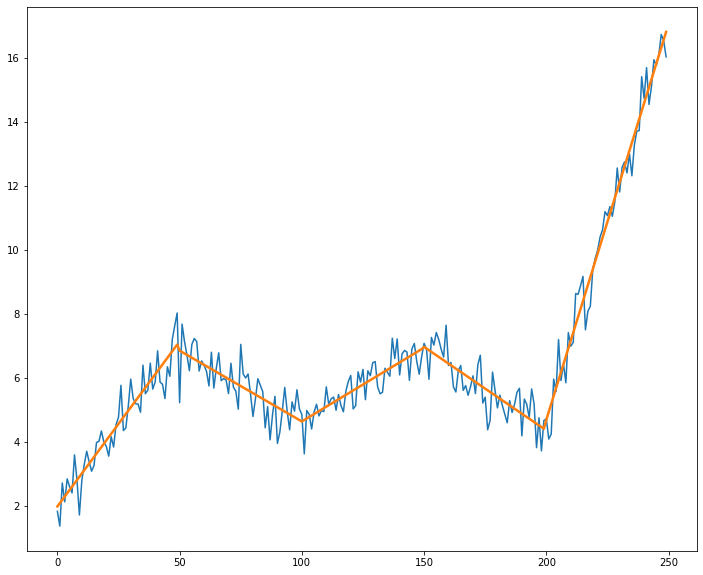

In [518]:
fig,ax=plt.subplots(figsize=(12,10))
plt.plot(x,y)
plt.plot(x,polynomials,lw=2.5)

In [519]:
n=len(true_changepoints)

optimal_segment=dp_solver(y,true_changepoints,K_max=n,k=1)
optimal_segment

(5, 5)
[13.4917045]
[13.4917045]
[13.4917045]
[13.4917045  39.05730037]
[13.4917045]
[13.4917045  39.05730037 53.6468187 ]
[13.4917045]
[0.]
[13.4917045]
[ 0.         23.43368145]
[13.4917045]
[0.]


array([[13.4917045 , 39.05730037, 53.6468187 , 69.69230517, 69.69230517],
       [ 0.        ,  0.        , 23.43368145, 39.47916792,  0.        ],
       [ 0.        ,  0.        ,  0.        , 30.63500479,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])